In [46]:
import sympy as sy
import random
import numpy as np
from tqdm import tqdm
import math
import pandas as pd

In [3]:
a, b = sy.symbols('a b')
x = sy.symbols('x')
y = sy.symbols('y')
I = sy.Integral(sy.sin(x)+x+2*x,(x,a,b))
print(sy.pretty(I))

b                  
⌠                  
⎮ (3⋅x + sin(x)) dx
⌡                  
a                  


In [4]:
int_func = sy.integrate(1/((2*math.pi)**(1/2))*sy.exp(-(x**2)/2),x)    #부정적분 생성(적분상수는 0)

# 값 넣어 계산

def p_value(v):
    v = abs(v)
    Fb = int_func.subs(x,10).evalf()         
    Fa = int_func.subs(x,v).evalf()

    return Fb-Fa



In [6]:

    
def check_sensitivity(m, std, trial, sample_size):
    p_values = []
    for i in tqdm(range(trial)) :
        samples = [random.gauss(m, std**2) for i in range(sample_size)]
        mean = np.array(samples).mean()
        p_values.append(p_value(mean))
    
    for h in [0.01, 0.03, 0.05]:
        count = list(np.array(p_values) < h).count(True)
        print(f"({h}): {count}")

for sample_size in range(1, 6):
    print(f"size: {sample_size}")
    check_sensitivity(0, 1, 10000, sample_size)

size: 1


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1090.63it/s]


(0.01): 209
(0.03): 591
(0.05): 1004
size: 2


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1082.49it/s]


(0.01): 9
(0.03): 65
(0.05): 190
size: 3


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1085.81it/s]


(0.01): 1
(0.03): 10
(0.05): 45
size: 4


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1104.09it/s]


(0.01): 0
(0.03): 1
(0.05): 13
size: 5


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1095.80it/s]


(0.01): 0
(0.03): 0
(0.05): 2


In [ ]:
for sample_size in range(1, 6):
    print(f"size: {sample_size}")
    check_sensitivity(0.1, 1, 10000, sample_size)

In [75]:
for sample_size in range(1, 6):
    print(f"size: {sample_size}")
    check_sensitivity(0.3, 1, 10000, sample_size)

size: 1


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1021.45it/s]


(0.01): 265
(0.03): 723
(0.05): 1169
size: 2


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1073.51it/s]


(0.01): 24
(0.03): 123
(0.05): 298
size: 3


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1032.84it/s]


(0.01): 0
(0.03): 35
(0.05): 90
size: 4


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1045.38it/s]


(0.01): 1
(0.03): 15
(0.05): 40
size: 5


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1057.24it/s]


(0.01): 0
(0.03): 0
(0.05): 4


In [36]:
import matplotlib.pyplot as plt
import numpy as np
int_func = sy.integrate(1/((2*math.pi)**(1/2))*sy.exp(-(x**2)/2),x)    #부정적분 생성(적분상수는 0)

class GMM:
    def __init__(self, gaussians, probability):
        self.gaussians = gaussians
        self.probability = np.array(probability)
        self.probability = list(self.probability/self.probability.sum())
        
    def get_sample(self):
        idx = np.random.choice(list(range(len(self.gaussians))), 1, self.probability).item()
        mean, std = self.gaussians[idx]
        return np.random.normal(mean, std)
    
    def mean(self):
        return np.array([gaussian[0] for gaussian in self.gaussians])@np.array(self.probability)
        
    def std(self):
        return (np.array([gaussian[1] for gaussian in self.gaussians])**2)@np.array(self.probability)
    
# GMM([(-1, 1), (1, 0.1)], [7, 3]).get_sample()

class Env:
    def __init__(self, gmms, trials):
        self.gmms = gmms
        self.trials = trials
        self.gmm_idx_list = sum([[i for x in range(n)] for i, n in enumerate(trials)], [])
        self.idx = -1
        
    def get_sample(self):
        if self.idx == len(self.gmm_idx_list)-1:
            return None
        else:
            self.idx += 1

            return self.gmms[self.gmm_idx_list[self.idx]].get_sample() 

        
    def get_mean_list(self):
        return sum([[self.gmms[i].mean() for x in range(n)] for i, n in enumerate(trials)], [])
        
    def get_std_list(self):
        return sum([[self.gmms[i].std() for x in range(n)] for i, n in enumerate(trials)], [])
    
    def reset(self):
        self.idx = -1
    
def p_value(v):
    v = abs(v)
    Fb = int_func.subs(x,10).evalf()         
    Fa = int_func.subs(x,v).evalf()

    return Fb-Fa

class Model:
    def __init__(self, buffer_size, threshold_smoothing, p_threshold, min_step_size, oblivion_step_size):
        self.mean = 0
        self.variance = 1
        self.p_threshold = p_threshold
        self.short_term_memory = []
        self.short_term_memory_buffer_size = buffer_size
        self.threshold_smoothing = threshold_smoothing
        self.size = 0
        self.size_after_init= 0
        self.min_step_size = min_step_size
        self.oblivion_step_size = oblivion_step_size
        
    def update(self, sample):
        if self.check_change():    
            p = self.short_memory_p_value()
            self.init_long_term_model()
                
        self.short_term_memory.append(sample)
        
        if(self.short_term_memory_buffer_size < len(self.short_term_memory)):
            sample = self.short_term_memory[0]
            self.size += 1
            self.size_after_init += 1
            self.variance += self.step_size()*((sample-self.mean)**2 - self.variance)
            self.mean += self.step_size()*(sample-self.mean)
            del self.short_term_memory[0] 

    def step_size(self):
        return max(self.min_step_size, 1/self.size)
        
    def print_distribution(self):
        print(self.mean, self.variance)
    
    def p_value(self, sample):
        z = (sample - self.mean)/(self.variance**(1/2))
        return p_value(z)
    
    def short_memory_p_value(self):
        sample = np.array(self.short_term_memory).mean()
        return self.p_value(sample)
    
    def check_change(self):
        if self.size == 0:
            return False
        
        p = self.short_memory_p_value()
        threshold = self.p_threshold*min(1, self.size_after_init/self.threshold_smoothing)
        return p<threshold
    
    def init_long_term_model(self):
        self.size = int(self.size*self.oblivion_step_size)
        self.size_after_init = 0


def test(model, env):
    size_list = []
    mean_list = []
    std_list = []
    while True:
        sample = env.get_sample()
        if sample == None:
            break
        model.update(sample)

        size_list.append(model.size)
        mean_list.append(model.mean)
        std_list.append(model.variance**(1/2))
    
    env_mean_list = env.get_mean_list()
    env_std_list = env.get_std_list()
    
#     print(np.array(env_mean_list).size)
#     print(np.array(env_std_list).size)
#     print(np.array(mean_list).size)
#     print(np.array(std_list).size)
    
    smd_list = standardized_mean_difference(np.array(env_mean_list), np.array(env_std_list), np.array(mean_list), np.array(std_list))
    return {"mean_list":mean_list, 
            "std_list":std_list, 
            "size_list":size_list,
           "smd_list":smd_list}

def standardized_mean_difference(m1, s1, m2, s2):
    return abs(m1-m2)/(((s1**2+s2**2)/2)**(1/2))

def show_size_and_smd_graph(size_list, smd_list):
    fig, ax1 = plt.subplots()
    ax1.plot(size_list, label=f"size")

    ax2 = ax1.twinx()
    ax2.set_ylim(0, 5)

    ax2.plot(smd_list, label=f"smd", color="green", linestyle = '--', linewidth = 1)

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

In [17]:
models = [Model(buffer_size=1, threshold_smoothing = 1),
          Model(buffer_size=2, threshold_smoothing = 1),
          Model(buffer_size=3, threshold_smoothing = 1),
          Model(buffer_size=4, threshold_smoothing = 1),
          Model(buffer_size=5, threshold_smoothing = 1)]
gmms = [GMM([(0, 1), (3, 0.1)], [7, 3]),
        GMM([(3, 1), (3, 0.1)], [7, 3]),
        GMM([(2, 1), (10, 0.1)], [7, 3]),
        GMM([(0, 1), (3, 0.1)], [7, 3])]
trials = [500, 500, 500, 500]
envs = [Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials)]

results = [test(model, env) for model, env in tqdm(zip(models, envs))]

5it [00:20,  4.15s/it]


0.3945787164038279
0.3860929118925334
0.5166557881946854
0.5534389933870629
0.5873807673673078


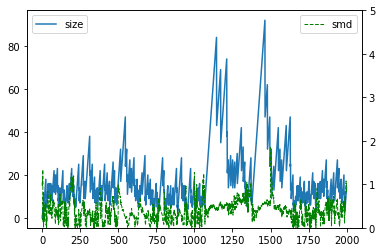

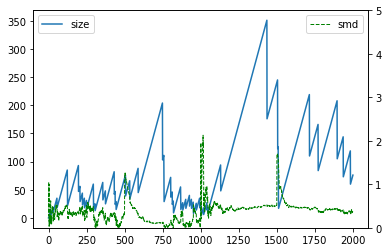

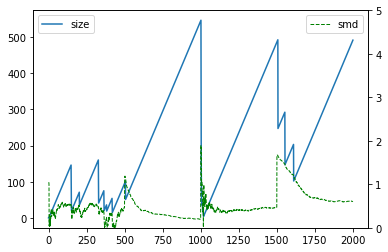

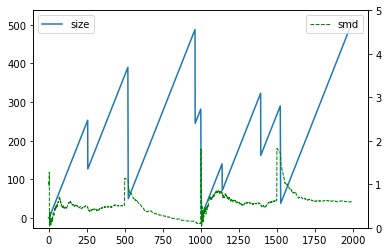

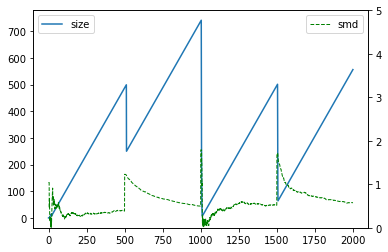

In [20]:
for i in range(5):
    show_size_and_smd_graph(results[i]["size_list"], results[i]["smd_list"])
    
for i in range(5):
    print(np.array(results[i]["smd_list"]).mean())

In [86]:
gmms = [GMM([(0, 1)], [1]),
        GMM([(0.1, 1)], [1]),
        GMM([(0.2, 1)], [1]),
        GMM([(0.3, 1)], [1]),
        GMM([(1, 1)], [1]),
        GMM([(2, 1)], [1]),
        GMM([(4, 1)], [1]),
        GMM([(7, 1)], [1])]
trials = [300 for i in range(len(gmms))]
envs = [Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials)]

models = [Model(buffer_size=1, threshold_smoothing = 1, p_threshold=0.1, min_step_size=0.01, oblivion_step_size = 1/10),
          Model(buffer_size=2, threshold_smoothing = 1, p_threshold=0.1, min_step_size=0.01, oblivion_step_size = 1/10),
          Model(buffer_size=3, threshold_smoothing = 1, p_threshold=0.1, min_step_size=0.01, oblivion_step_size = 1/10),
          Model(buffer_size=4, threshold_smoothing = 1, p_threshold=0.1, min_step_size=0.01, oblivion_step_size = 1/10),
          ]


buffer_size_list = list(range(1, 10))
threshold_smoothing_list = [1]
p_threshold_list = [0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
min_step_size_list = list(np.array(range(1, 31))/1000)
oblivion_step_size_list = list(1/np.array(range(1, 11)))

progress = 0
results = []
for buffer_size in buffer_size_list: # 5
    for threshold_smoothing in threshold_smoothing_list: # 1
        for p_threshold in p_threshold_list: # 10
            for min_step_size in min_step_size_list: #4
                for oblivion_step_size in oblivion_step_size_list: # 9
                    progress += 1
                    print("progress: ",progress)
                    
                    model = Model(buffer_size=buffer_size, 
                                  threshold_smoothing = threshold_smoothing, 
                                  p_threshold=p_threshold, 
                                  min_step_size=min_step_size, 
                                  oblivion_step_size = oblivion_step_size)
                    env = Env(gmms, trials)
                    result = test(model, env)
                    results.append((buffer_size, threshold_smoothing, p_threshold, min_step_size, oblivion_step_size, result))

# 5, 1, 9, 1, 7

progress:  1
progress:  2
progress:  3
progress:  4
progress:  5
progress:  6
progress:  7
progress:  8
progress:  9
progress:  10
progress:  11
progress:  12
progress:  13
progress:  14
progress:  15
progress:  16
progress:  17
progress:  18
progress:  19
progress:  20
progress:  21
progress:  22
progress:  23
progress:  24
progress:  25
progress:  26
progress:  27
progress:  28
progress:  29
progress:  30
progress:  31
progress:  32
progress:  33
progress:  34
progress:  35
progress:  36
progress:  37
progress:  38
progress:  39
progress:  40
progress:  41
progress:  42
progress:  43
progress:  44
progress:  45
progress:  46
progress:  47
progress:  48
progress:  49
progress:  50
progress:  51
progress:  52
progress:  53
progress:  54
progress:  55
progress:  56
progress:  57
progress:  58
progress:  59
progress:  60
progress:  61
progress:  62
progress:  63
progress:  64
progress:  65
progress:  66
progress:  67
progress:  68
progress:  69
progress:  70
progress:  71
progress:  72
p

progress:  555
progress:  556
progress:  557
progress:  558
progress:  559
progress:  560
progress:  561
progress:  562
progress:  563
progress:  564
progress:  565
progress:  566
progress:  567
progress:  568
progress:  569
progress:  570
progress:  571
progress:  572
progress:  573
progress:  574
progress:  575
progress:  576
progress:  577
progress:  578
progress:  579
progress:  580
progress:  581
progress:  582
progress:  583
progress:  584
progress:  585
progress:  586
progress:  587
progress:  588
progress:  589
progress:  590
progress:  591
progress:  592
progress:  593
progress:  594
progress:  595
progress:  596
progress:  597
progress:  598
progress:  599
progress:  600
progress:  601
progress:  602
progress:  603
progress:  604
progress:  605
progress:  606
progress:  607
progress:  608
progress:  609
progress:  610
progress:  611
progress:  612
progress:  613
progress:  614
progress:  615
progress:  616
progress:  617
progress:  618
progress:  619
progress:  620
progress: 

progress:  1095
progress:  1096
progress:  1097
progress:  1098
progress:  1099
progress:  1100
progress:  1101
progress:  1102
progress:  1103
progress:  1104
progress:  1105
progress:  1106
progress:  1107
progress:  1108
progress:  1109
progress:  1110
progress:  1111
progress:  1112
progress:  1113
progress:  1114
progress:  1115
progress:  1116
progress:  1117
progress:  1118
progress:  1119
progress:  1120
progress:  1121
progress:  1122
progress:  1123
progress:  1124
progress:  1125
progress:  1126
progress:  1127
progress:  1128
progress:  1129
progress:  1130
progress:  1131
progress:  1132
progress:  1133
progress:  1134
progress:  1135
progress:  1136
progress:  1137
progress:  1138
progress:  1139
progress:  1140
progress:  1141
progress:  1142
progress:  1143
progress:  1144
progress:  1145
progress:  1146
progress:  1147
progress:  1148
progress:  1149
progress:  1150
progress:  1151
progress:  1152
progress:  1153
progress:  1154
progress:  1155
progress:  1156
progress

progress:  1608
progress:  1609
progress:  1610
progress:  1611
progress:  1612
progress:  1613
progress:  1614
progress:  1615
progress:  1616
progress:  1617
progress:  1618
progress:  1619
progress:  1620
progress:  1621
progress:  1622
progress:  1623
progress:  1624
progress:  1625
progress:  1626
progress:  1627
progress:  1628
progress:  1629
progress:  1630
progress:  1631
progress:  1632
progress:  1633
progress:  1634
progress:  1635
progress:  1636
progress:  1637
progress:  1638
progress:  1639
progress:  1640
progress:  1641
progress:  1642
progress:  1643
progress:  1644
progress:  1645
progress:  1646
progress:  1647
progress:  1648
progress:  1649
progress:  1650
progress:  1651
progress:  1652
progress:  1653
progress:  1654
progress:  1655
progress:  1656
progress:  1657
progress:  1658
progress:  1659
progress:  1660
progress:  1661
progress:  1662
progress:  1663
progress:  1664
progress:  1665
progress:  1666
progress:  1667
progress:  1668
progress:  1669
progress

progress:  2121
progress:  2122
progress:  2123
progress:  2124
progress:  2125
progress:  2126
progress:  2127
progress:  2128
progress:  2129
progress:  2130
progress:  2131
progress:  2132
progress:  2133
progress:  2134
progress:  2135
progress:  2136
progress:  2137
progress:  2138
progress:  2139
progress:  2140
progress:  2141
progress:  2142
progress:  2143
progress:  2144
progress:  2145
progress:  2146
progress:  2147
progress:  2148
progress:  2149
progress:  2150
progress:  2151
progress:  2152
progress:  2153
progress:  2154
progress:  2155
progress:  2156
progress:  2157
progress:  2158
progress:  2159
progress:  2160
progress:  2161
progress:  2162
progress:  2163
progress:  2164
progress:  2165
progress:  2166
progress:  2167
progress:  2168
progress:  2169
progress:  2170
progress:  2171
progress:  2172
progress:  2173
progress:  2174
progress:  2175
progress:  2176
progress:  2177
progress:  2178
progress:  2179
progress:  2180
progress:  2181
progress:  2182
progress

progress:  2634
progress:  2635
progress:  2636
progress:  2637
progress:  2638
progress:  2639
progress:  2640
progress:  2641
progress:  2642
progress:  2643
progress:  2644
progress:  2645
progress:  2646
progress:  2647
progress:  2648
progress:  2649
progress:  2650
progress:  2651
progress:  2652
progress:  2653
progress:  2654
progress:  2655
progress:  2656
progress:  2657
progress:  2658
progress:  2659
progress:  2660
progress:  2661
progress:  2662
progress:  2663
progress:  2664
progress:  2665
progress:  2666
progress:  2667
progress:  2668
progress:  2669
progress:  2670
progress:  2671
progress:  2672
progress:  2673
progress:  2674
progress:  2675
progress:  2676
progress:  2677
progress:  2678
progress:  2679
progress:  2680
progress:  2681
progress:  2682
progress:  2683
progress:  2684
progress:  2685
progress:  2686
progress:  2687
progress:  2688
progress:  2689
progress:  2690
progress:  2691
progress:  2692
progress:  2693
progress:  2694
progress:  2695
progress

progress:  3147
progress:  3148
progress:  3149
progress:  3150
progress:  3151
progress:  3152
progress:  3153
progress:  3154
progress:  3155
progress:  3156
progress:  3157
progress:  3158
progress:  3159
progress:  3160
progress:  3161
progress:  3162
progress:  3163
progress:  3164
progress:  3165
progress:  3166
progress:  3167
progress:  3168
progress:  3169
progress:  3170
progress:  3171
progress:  3172
progress:  3173
progress:  3174
progress:  3175
progress:  3176
progress:  3177
progress:  3178
progress:  3179
progress:  3180
progress:  3181
progress:  3182
progress:  3183
progress:  3184
progress:  3185
progress:  3186
progress:  3187
progress:  3188
progress:  3189
progress:  3190
progress:  3191
progress:  3192
progress:  3193
progress:  3194
progress:  3195
progress:  3196
progress:  3197
progress:  3198
progress:  3199
progress:  3200
progress:  3201
progress:  3202
progress:  3203
progress:  3204
progress:  3205
progress:  3206
progress:  3207
progress:  3208
progress

progress:  3660
progress:  3661
progress:  3662
progress:  3663
progress:  3664
progress:  3665
progress:  3666
progress:  3667
progress:  3668
progress:  3669
progress:  3670
progress:  3671
progress:  3672
progress:  3673
progress:  3674
progress:  3675
progress:  3676
progress:  3677
progress:  3678
progress:  3679
progress:  3680
progress:  3681
progress:  3682
progress:  3683
progress:  3684
progress:  3685
progress:  3686
progress:  3687
progress:  3688
progress:  3689
progress:  3690
progress:  3691
progress:  3692
progress:  3693
progress:  3694
progress:  3695
progress:  3696
progress:  3697
progress:  3698
progress:  3699
progress:  3700
progress:  3701
progress:  3702
progress:  3703
progress:  3704
progress:  3705
progress:  3706
progress:  3707
progress:  3708
progress:  3709
progress:  3710
progress:  3711
progress:  3712
progress:  3713
progress:  3714
progress:  3715
progress:  3716
progress:  3717
progress:  3718
progress:  3719
progress:  3720
progress:  3721
progress

progress:  4173
progress:  4174
progress:  4175
progress:  4176
progress:  4177
progress:  4178
progress:  4179
progress:  4180
progress:  4181
progress:  4182
progress:  4183
progress:  4184
progress:  4185
progress:  4186
progress:  4187
progress:  4188
progress:  4189
progress:  4190
progress:  4191
progress:  4192
progress:  4193
progress:  4194
progress:  4195
progress:  4196
progress:  4197
progress:  4198
progress:  4199
progress:  4200
progress:  4201
progress:  4202
progress:  4203
progress:  4204
progress:  4205
progress:  4206
progress:  4207
progress:  4208
progress:  4209
progress:  4210
progress:  4211
progress:  4212
progress:  4213
progress:  4214
progress:  4215
progress:  4216
progress:  4217
progress:  4218
progress:  4219
progress:  4220
progress:  4221
progress:  4222
progress:  4223
progress:  4224
progress:  4225
progress:  4226
progress:  4227
progress:  4228
progress:  4229
progress:  4230
progress:  4231
progress:  4232
progress:  4233
progress:  4234
progress

progress:  4686
progress:  4687
progress:  4688
progress:  4689
progress:  4690
progress:  4691
progress:  4692
progress:  4693
progress:  4694
progress:  4695
progress:  4696
progress:  4697
progress:  4698
progress:  4699
progress:  4700
progress:  4701
progress:  4702
progress:  4703
progress:  4704
progress:  4705
progress:  4706
progress:  4707
progress:  4708
progress:  4709
progress:  4710
progress:  4711
progress:  4712
progress:  4713
progress:  4714
progress:  4715
progress:  4716
progress:  4717
progress:  4718
progress:  4719
progress:  4720
progress:  4721
progress:  4722
progress:  4723
progress:  4724
progress:  4725
progress:  4726
progress:  4727
progress:  4728
progress:  4729
progress:  4730
progress:  4731
progress:  4732
progress:  4733
progress:  4734
progress:  4735
progress:  4736
progress:  4737
progress:  4738
progress:  4739
progress:  4740
progress:  4741
progress:  4742
progress:  4743
progress:  4744
progress:  4745
progress:  4746
progress:  4747
progress

progress:  5199
progress:  5200
progress:  5201
progress:  5202
progress:  5203
progress:  5204
progress:  5205
progress:  5206
progress:  5207
progress:  5208
progress:  5209
progress:  5210
progress:  5211
progress:  5212
progress:  5213
progress:  5214
progress:  5215
progress:  5216
progress:  5217
progress:  5218
progress:  5219
progress:  5220
progress:  5221
progress:  5222
progress:  5223
progress:  5224
progress:  5225
progress:  5226
progress:  5227
progress:  5228
progress:  5229
progress:  5230
progress:  5231
progress:  5232
progress:  5233
progress:  5234
progress:  5235
progress:  5236
progress:  5237
progress:  5238
progress:  5239
progress:  5240
progress:  5241
progress:  5242
progress:  5243
progress:  5244
progress:  5245
progress:  5246
progress:  5247
progress:  5248
progress:  5249
progress:  5250
progress:  5251
progress:  5252
progress:  5253
progress:  5254
progress:  5255
progress:  5256
progress:  5257
progress:  5258
progress:  5259
progress:  5260
progress

progress:  5712
progress:  5713
progress:  5714
progress:  5715
progress:  5716
progress:  5717
progress:  5718
progress:  5719
progress:  5720
progress:  5721
progress:  5722
progress:  5723
progress:  5724
progress:  5725
progress:  5726
progress:  5727
progress:  5728
progress:  5729
progress:  5730
progress:  5731
progress:  5732
progress:  5733
progress:  5734
progress:  5735
progress:  5736
progress:  5737
progress:  5738
progress:  5739
progress:  5740
progress:  5741
progress:  5742
progress:  5743
progress:  5744
progress:  5745
progress:  5746
progress:  5747
progress:  5748
progress:  5749
progress:  5750
progress:  5751
progress:  5752
progress:  5753
progress:  5754
progress:  5755
progress:  5756
progress:  5757
progress:  5758
progress:  5759
progress:  5760
progress:  5761
progress:  5762
progress:  5763
progress:  5764
progress:  5765
progress:  5766
progress:  5767
progress:  5768
progress:  5769
progress:  5770
progress:  5771
progress:  5772
progress:  5773
progress

progress:  6225
progress:  6226
progress:  6227
progress:  6228
progress:  6229
progress:  6230
progress:  6231
progress:  6232
progress:  6233
progress:  6234
progress:  6235
progress:  6236
progress:  6237
progress:  6238
progress:  6239
progress:  6240
progress:  6241
progress:  6242
progress:  6243
progress:  6244
progress:  6245
progress:  6246
progress:  6247
progress:  6248
progress:  6249
progress:  6250
progress:  6251
progress:  6252
progress:  6253
progress:  6254
progress:  6255
progress:  6256
progress:  6257
progress:  6258
progress:  6259
progress:  6260
progress:  6261
progress:  6262
progress:  6263
progress:  6264
progress:  6265
progress:  6266
progress:  6267
progress:  6268
progress:  6269
progress:  6270
progress:  6271
progress:  6272
progress:  6273
progress:  6274
progress:  6275
progress:  6276
progress:  6277
progress:  6278
progress:  6279
progress:  6280
progress:  6281
progress:  6282
progress:  6283
progress:  6284
progress:  6285
progress:  6286
progress

progress:  6738
progress:  6739
progress:  6740
progress:  6741
progress:  6742
progress:  6743
progress:  6744
progress:  6745
progress:  6746
progress:  6747
progress:  6748
progress:  6749
progress:  6750
progress:  6751
progress:  6752
progress:  6753
progress:  6754
progress:  6755
progress:  6756
progress:  6757
progress:  6758
progress:  6759
progress:  6760
progress:  6761
progress:  6762
progress:  6763
progress:  6764
progress:  6765
progress:  6766
progress:  6767
progress:  6768
progress:  6769
progress:  6770
progress:  6771
progress:  6772
progress:  6773
progress:  6774
progress:  6775
progress:  6776
progress:  6777
progress:  6778
progress:  6779
progress:  6780
progress:  6781
progress:  6782
progress:  6783
progress:  6784
progress:  6785
progress:  6786
progress:  6787
progress:  6788
progress:  6789
progress:  6790
progress:  6791
progress:  6792
progress:  6793
progress:  6794
progress:  6795
progress:  6796
progress:  6797
progress:  6798
progress:  6799
progress

progress:  7251
progress:  7252
progress:  7253
progress:  7254
progress:  7255
progress:  7256
progress:  7257
progress:  7258
progress:  7259
progress:  7260
progress:  7261
progress:  7262
progress:  7263
progress:  7264
progress:  7265
progress:  7266
progress:  7267
progress:  7268
progress:  7269
progress:  7270
progress:  7271
progress:  7272
progress:  7273
progress:  7274
progress:  7275
progress:  7276
progress:  7277
progress:  7278
progress:  7279
progress:  7280
progress:  7281
progress:  7282
progress:  7283
progress:  7284
progress:  7285
progress:  7286
progress:  7287
progress:  7288
progress:  7289
progress:  7290
progress:  7291
progress:  7292
progress:  7293
progress:  7294
progress:  7295
progress:  7296
progress:  7297
progress:  7298
progress:  7299
progress:  7300
progress:  7301
progress:  7302
progress:  7303
progress:  7304
progress:  7305
progress:  7306
progress:  7307
progress:  7308
progress:  7309
progress:  7310
progress:  7311
progress:  7312
progress

progress:  7764
progress:  7765
progress:  7766
progress:  7767
progress:  7768
progress:  7769
progress:  7770
progress:  7771
progress:  7772
progress:  7773
progress:  7774
progress:  7775
progress:  7776
progress:  7777
progress:  7778
progress:  7779
progress:  7780
progress:  7781
progress:  7782
progress:  7783
progress:  7784
progress:  7785
progress:  7786
progress:  7787
progress:  7788
progress:  7789
progress:  7790
progress:  7791
progress:  7792
progress:  7793
progress:  7794
progress:  7795
progress:  7796
progress:  7797
progress:  7798
progress:  7799
progress:  7800
progress:  7801
progress:  7802
progress:  7803
progress:  7804
progress:  7805
progress:  7806
progress:  7807
progress:  7808
progress:  7809
progress:  7810
progress:  7811
progress:  7812
progress:  7813
progress:  7814
progress:  7815
progress:  7816
progress:  7817
progress:  7818
progress:  7819
progress:  7820
progress:  7821
progress:  7822
progress:  7823
progress:  7824
progress:  7825
progress

progress:  8277
progress:  8278
progress:  8279
progress:  8280
progress:  8281
progress:  8282
progress:  8283
progress:  8284
progress:  8285
progress:  8286
progress:  8287
progress:  8288
progress:  8289
progress:  8290
progress:  8291
progress:  8292
progress:  8293
progress:  8294
progress:  8295
progress:  8296
progress:  8297
progress:  8298
progress:  8299
progress:  8300
progress:  8301
progress:  8302
progress:  8303
progress:  8304
progress:  8305
progress:  8306
progress:  8307
progress:  8308
progress:  8309
progress:  8310
progress:  8311
progress:  8312
progress:  8313
progress:  8314
progress:  8315
progress:  8316
progress:  8317
progress:  8318
progress:  8319
progress:  8320
progress:  8321
progress:  8322
progress:  8323
progress:  8324
progress:  8325
progress:  8326
progress:  8327
progress:  8328
progress:  8329
progress:  8330
progress:  8331
progress:  8332
progress:  8333
progress:  8334
progress:  8335
progress:  8336
progress:  8337
progress:  8338
progress

progress:  8790
progress:  8791
progress:  8792
progress:  8793
progress:  8794
progress:  8795
progress:  8796
progress:  8797
progress:  8798
progress:  8799
progress:  8800
progress:  8801
progress:  8802
progress:  8803
progress:  8804
progress:  8805
progress:  8806
progress:  8807
progress:  8808
progress:  8809
progress:  8810
progress:  8811
progress:  8812
progress:  8813
progress:  8814
progress:  8815
progress:  8816
progress:  8817
progress:  8818
progress:  8819
progress:  8820
progress:  8821
progress:  8822
progress:  8823
progress:  8824
progress:  8825
progress:  8826
progress:  8827
progress:  8828
progress:  8829
progress:  8830
progress:  8831
progress:  8832
progress:  8833
progress:  8834
progress:  8835
progress:  8836
progress:  8837
progress:  8838
progress:  8839
progress:  8840
progress:  8841
progress:  8842
progress:  8843
progress:  8844
progress:  8845
progress:  8846
progress:  8847
progress:  8848
progress:  8849
progress:  8850
progress:  8851
progress

progress:  9303
progress:  9304
progress:  9305
progress:  9306
progress:  9307
progress:  9308
progress:  9309
progress:  9310
progress:  9311
progress:  9312
progress:  9313
progress:  9314
progress:  9315
progress:  9316
progress:  9317
progress:  9318
progress:  9319
progress:  9320
progress:  9321
progress:  9322
progress:  9323
progress:  9324
progress:  9325
progress:  9326
progress:  9327
progress:  9328
progress:  9329
progress:  9330
progress:  9331
progress:  9332
progress:  9333
progress:  9334
progress:  9335
progress:  9336
progress:  9337
progress:  9338
progress:  9339
progress:  9340
progress:  9341
progress:  9342
progress:  9343
progress:  9344
progress:  9345
progress:  9346
progress:  9347
progress:  9348
progress:  9349
progress:  9350
progress:  9351
progress:  9352
progress:  9353
progress:  9354
progress:  9355
progress:  9356
progress:  9357
progress:  9358
progress:  9359
progress:  9360
progress:  9361
progress:  9362
progress:  9363
progress:  9364
progress

progress:  9816
progress:  9817
progress:  9818
progress:  9819
progress:  9820
progress:  9821
progress:  9822
progress:  9823
progress:  9824
progress:  9825
progress:  9826
progress:  9827
progress:  9828
progress:  9829
progress:  9830
progress:  9831
progress:  9832
progress:  9833
progress:  9834
progress:  9835
progress:  9836
progress:  9837
progress:  9838
progress:  9839
progress:  9840
progress:  9841
progress:  9842
progress:  9843
progress:  9844
progress:  9845
progress:  9846
progress:  9847
progress:  9848
progress:  9849
progress:  9850
progress:  9851
progress:  9852
progress:  9853
progress:  9854
progress:  9855
progress:  9856
progress:  9857
progress:  9858
progress:  9859
progress:  9860
progress:  9861
progress:  9862
progress:  9863
progress:  9864
progress:  9865
progress:  9866
progress:  9867
progress:  9868
progress:  9869
progress:  9870
progress:  9871
progress:  9872
progress:  9873
progress:  9874
progress:  9875
progress:  9876
progress:  9877
progress

progress:  10309
progress:  10310
progress:  10311
progress:  10312
progress:  10313
progress:  10314
progress:  10315
progress:  10316
progress:  10317
progress:  10318
progress:  10319
progress:  10320
progress:  10321
progress:  10322
progress:  10323
progress:  10324
progress:  10325
progress:  10326
progress:  10327
progress:  10328
progress:  10329
progress:  10330
progress:  10331
progress:  10332
progress:  10333
progress:  10334
progress:  10335
progress:  10336
progress:  10337
progress:  10338
progress:  10339
progress:  10340
progress:  10341
progress:  10342
progress:  10343
progress:  10344
progress:  10345
progress:  10346
progress:  10347
progress:  10348
progress:  10349
progress:  10350
progress:  10351
progress:  10352
progress:  10353
progress:  10354
progress:  10355
progress:  10356
progress:  10357
progress:  10358
progress:  10359
progress:  10360
progress:  10361
progress:  10362
progress:  10363
progress:  10364
progress:  10365
progress:  10366
progress:  103

progress:  10791
progress:  10792
progress:  10793
progress:  10794
progress:  10795
progress:  10796
progress:  10797
progress:  10798
progress:  10799
progress:  10800
progress:  10801
progress:  10802
progress:  10803
progress:  10804
progress:  10805
progress:  10806
progress:  10807
progress:  10808
progress:  10809
progress:  10810
progress:  10811
progress:  10812
progress:  10813
progress:  10814
progress:  10815
progress:  10816
progress:  10817
progress:  10818
progress:  10819
progress:  10820
progress:  10821
progress:  10822
progress:  10823
progress:  10824
progress:  10825
progress:  10826
progress:  10827
progress:  10828
progress:  10829
progress:  10830
progress:  10831
progress:  10832
progress:  10833
progress:  10834
progress:  10835
progress:  10836
progress:  10837
progress:  10838
progress:  10839
progress:  10840
progress:  10841
progress:  10842
progress:  10843
progress:  10844
progress:  10845
progress:  10846
progress:  10847
progress:  10848
progress:  108

progress:  11273
progress:  11274
progress:  11275
progress:  11276
progress:  11277
progress:  11278
progress:  11279
progress:  11280
progress:  11281
progress:  11282
progress:  11283
progress:  11284
progress:  11285
progress:  11286
progress:  11287
progress:  11288
progress:  11289
progress:  11290
progress:  11291
progress:  11292
progress:  11293
progress:  11294
progress:  11295
progress:  11296
progress:  11297
progress:  11298
progress:  11299
progress:  11300
progress:  11301
progress:  11302
progress:  11303
progress:  11304
progress:  11305
progress:  11306
progress:  11307
progress:  11308
progress:  11309
progress:  11310
progress:  11311
progress:  11312
progress:  11313
progress:  11314
progress:  11315
progress:  11316
progress:  11317
progress:  11318
progress:  11319
progress:  11320
progress:  11321
progress:  11322
progress:  11323
progress:  11324
progress:  11325
progress:  11326
progress:  11327
progress:  11328
progress:  11329
progress:  11330
progress:  113

progress:  11755
progress:  11756
progress:  11757
progress:  11758
progress:  11759
progress:  11760
progress:  11761
progress:  11762
progress:  11763
progress:  11764
progress:  11765
progress:  11766
progress:  11767
progress:  11768
progress:  11769
progress:  11770
progress:  11771
progress:  11772
progress:  11773
progress:  11774
progress:  11775
progress:  11776
progress:  11777
progress:  11778
progress:  11779
progress:  11780
progress:  11781
progress:  11782
progress:  11783
progress:  11784
progress:  11785
progress:  11786
progress:  11787
progress:  11788
progress:  11789
progress:  11790
progress:  11791
progress:  11792
progress:  11793
progress:  11794
progress:  11795
progress:  11796
progress:  11797
progress:  11798
progress:  11799
progress:  11800
progress:  11801
progress:  11802
progress:  11803
progress:  11804
progress:  11805
progress:  11806
progress:  11807
progress:  11808
progress:  11809
progress:  11810
progress:  11811
progress:  11812
progress:  118

progress:  12237
progress:  12238
progress:  12239
progress:  12240
progress:  12241
progress:  12242
progress:  12243
progress:  12244
progress:  12245
progress:  12246
progress:  12247
progress:  12248
progress:  12249
progress:  12250
progress:  12251
progress:  12252
progress:  12253
progress:  12254
progress:  12255
progress:  12256
progress:  12257
progress:  12258
progress:  12259
progress:  12260
progress:  12261
progress:  12262
progress:  12263
progress:  12264
progress:  12265
progress:  12266
progress:  12267
progress:  12268
progress:  12269
progress:  12270
progress:  12271
progress:  12272
progress:  12273
progress:  12274
progress:  12275
progress:  12276
progress:  12277
progress:  12278
progress:  12279
progress:  12280
progress:  12281
progress:  12282
progress:  12283
progress:  12284
progress:  12285
progress:  12286
progress:  12287
progress:  12288
progress:  12289
progress:  12290
progress:  12291
progress:  12292
progress:  12293
progress:  12294
progress:  122

progress:  12719
progress:  12720
progress:  12721
progress:  12722
progress:  12723
progress:  12724
progress:  12725
progress:  12726
progress:  12727
progress:  12728
progress:  12729
progress:  12730
progress:  12731
progress:  12732
progress:  12733
progress:  12734
progress:  12735
progress:  12736
progress:  12737
progress:  12738
progress:  12739
progress:  12740
progress:  12741
progress:  12742
progress:  12743
progress:  12744
progress:  12745
progress:  12746
progress:  12747
progress:  12748
progress:  12749
progress:  12750
progress:  12751
progress:  12752
progress:  12753
progress:  12754
progress:  12755
progress:  12756
progress:  12757
progress:  12758
progress:  12759
progress:  12760
progress:  12761
progress:  12762
progress:  12763
progress:  12764
progress:  12765
progress:  12766
progress:  12767
progress:  12768
progress:  12769
progress:  12770
progress:  12771
progress:  12772
progress:  12773
progress:  12774
progress:  12775
progress:  12776
progress:  127

progress:  13201
progress:  13202
progress:  13203
progress:  13204
progress:  13205
progress:  13206
progress:  13207
progress:  13208
progress:  13209
progress:  13210
progress:  13211
progress:  13212
progress:  13213
progress:  13214
progress:  13215
progress:  13216
progress:  13217
progress:  13218
progress:  13219
progress:  13220
progress:  13221
progress:  13222
progress:  13223
progress:  13224
progress:  13225
progress:  13226
progress:  13227
progress:  13228
progress:  13229
progress:  13230
progress:  13231
progress:  13232
progress:  13233
progress:  13234
progress:  13235
progress:  13236
progress:  13237
progress:  13238
progress:  13239
progress:  13240
progress:  13241
progress:  13242
progress:  13243
progress:  13244
progress:  13245
progress:  13246
progress:  13247
progress:  13248
progress:  13249
progress:  13250
progress:  13251
progress:  13252
progress:  13253
progress:  13254
progress:  13255
progress:  13256
progress:  13257
progress:  13258
progress:  132

progress:  13683
progress:  13684
progress:  13685
progress:  13686
progress:  13687
progress:  13688
progress:  13689
progress:  13690
progress:  13691
progress:  13692
progress:  13693
progress:  13694
progress:  13695
progress:  13696
progress:  13697
progress:  13698
progress:  13699
progress:  13700
progress:  13701
progress:  13702
progress:  13703
progress:  13704
progress:  13705
progress:  13706
progress:  13707
progress:  13708
progress:  13709
progress:  13710
progress:  13711
progress:  13712
progress:  13713
progress:  13714
progress:  13715
progress:  13716
progress:  13717
progress:  13718
progress:  13719
progress:  13720
progress:  13721
progress:  13722
progress:  13723
progress:  13724
progress:  13725
progress:  13726
progress:  13727
progress:  13728
progress:  13729
progress:  13730
progress:  13731
progress:  13732
progress:  13733
progress:  13734
progress:  13735
progress:  13736
progress:  13737
progress:  13738
progress:  13739
progress:  13740
progress:  137

progress:  14165
progress:  14166
progress:  14167
progress:  14168
progress:  14169
progress:  14170
progress:  14171
progress:  14172
progress:  14173
progress:  14174
progress:  14175
progress:  14176
progress:  14177
progress:  14178
progress:  14179
progress:  14180
progress:  14181
progress:  14182
progress:  14183
progress:  14184
progress:  14185
progress:  14186
progress:  14187
progress:  14188
progress:  14189
progress:  14190
progress:  14191
progress:  14192
progress:  14193
progress:  14194
progress:  14195
progress:  14196
progress:  14197
progress:  14198
progress:  14199
progress:  14200
progress:  14201
progress:  14202
progress:  14203
progress:  14204
progress:  14205
progress:  14206
progress:  14207
progress:  14208
progress:  14209
progress:  14210
progress:  14211
progress:  14212
progress:  14213
progress:  14214
progress:  14215
progress:  14216
progress:  14217
progress:  14218
progress:  14219
progress:  14220
progress:  14221
progress:  14222
progress:  142

progress:  14647
progress:  14648
progress:  14649
progress:  14650
progress:  14651
progress:  14652
progress:  14653
progress:  14654
progress:  14655
progress:  14656
progress:  14657
progress:  14658
progress:  14659
progress:  14660
progress:  14661
progress:  14662
progress:  14663
progress:  14664
progress:  14665
progress:  14666
progress:  14667
progress:  14668
progress:  14669
progress:  14670
progress:  14671
progress:  14672
progress:  14673
progress:  14674
progress:  14675
progress:  14676
progress:  14677
progress:  14678
progress:  14679
progress:  14680
progress:  14681
progress:  14682
progress:  14683
progress:  14684
progress:  14685
progress:  14686
progress:  14687
progress:  14688
progress:  14689
progress:  14690
progress:  14691
progress:  14692
progress:  14693
progress:  14694
progress:  14695
progress:  14696
progress:  14697
progress:  14698
progress:  14699
progress:  14700
progress:  14701
progress:  14702
progress:  14703
progress:  14704
progress:  147

progress:  15129
progress:  15130
progress:  15131
progress:  15132
progress:  15133
progress:  15134
progress:  15135
progress:  15136
progress:  15137
progress:  15138
progress:  15139
progress:  15140
progress:  15141
progress:  15142
progress:  15143
progress:  15144
progress:  15145
progress:  15146
progress:  15147
progress:  15148
progress:  15149
progress:  15150
progress:  15151
progress:  15152
progress:  15153
progress:  15154
progress:  15155
progress:  15156
progress:  15157
progress:  15158
progress:  15159
progress:  15160
progress:  15161
progress:  15162
progress:  15163
progress:  15164
progress:  15165
progress:  15166
progress:  15167
progress:  15168
progress:  15169
progress:  15170
progress:  15171
progress:  15172
progress:  15173
progress:  15174
progress:  15175
progress:  15176
progress:  15177
progress:  15178
progress:  15179
progress:  15180
progress:  15181
progress:  15182
progress:  15183
progress:  15184
progress:  15185
progress:  15186
progress:  151

progress:  15611
progress:  15612
progress:  15613
progress:  15614
progress:  15615
progress:  15616
progress:  15617
progress:  15618
progress:  15619
progress:  15620
progress:  15621
progress:  15622
progress:  15623
progress:  15624
progress:  15625
progress:  15626
progress:  15627
progress:  15628
progress:  15629
progress:  15630
progress:  15631
progress:  15632
progress:  15633
progress:  15634
progress:  15635
progress:  15636
progress:  15637
progress:  15638
progress:  15639
progress:  15640
progress:  15641
progress:  15642
progress:  15643
progress:  15644
progress:  15645
progress:  15646
progress:  15647
progress:  15648
progress:  15649
progress:  15650
progress:  15651
progress:  15652
progress:  15653
progress:  15654
progress:  15655
progress:  15656
progress:  15657
progress:  15658
progress:  15659
progress:  15660
progress:  15661
progress:  15662
progress:  15663
progress:  15664
progress:  15665
progress:  15666
progress:  15667
progress:  15668
progress:  156

progress:  16093
progress:  16094
progress:  16095
progress:  16096
progress:  16097
progress:  16098
progress:  16099
progress:  16100
progress:  16101
progress:  16102
progress:  16103
progress:  16104
progress:  16105
progress:  16106
progress:  16107
progress:  16108
progress:  16109
progress:  16110
progress:  16111
progress:  16112
progress:  16113
progress:  16114
progress:  16115
progress:  16116
progress:  16117
progress:  16118
progress:  16119
progress:  16120
progress:  16121
progress:  16122
progress:  16123
progress:  16124
progress:  16125
progress:  16126
progress:  16127
progress:  16128
progress:  16129
progress:  16130
progress:  16131
progress:  16132
progress:  16133
progress:  16134
progress:  16135
progress:  16136
progress:  16137
progress:  16138
progress:  16139
progress:  16140
progress:  16141
progress:  16142
progress:  16143
progress:  16144
progress:  16145
progress:  16146
progress:  16147
progress:  16148
progress:  16149
progress:  16150
progress:  161

progress:  16575
progress:  16576
progress:  16577
progress:  16578
progress:  16579
progress:  16580
progress:  16581
progress:  16582
progress:  16583
progress:  16584
progress:  16585
progress:  16586
progress:  16587
progress:  16588
progress:  16589
progress:  16590
progress:  16591
progress:  16592
progress:  16593
progress:  16594
progress:  16595
progress:  16596
progress:  16597
progress:  16598
progress:  16599
progress:  16600
progress:  16601
progress:  16602
progress:  16603
progress:  16604
progress:  16605
progress:  16606
progress:  16607
progress:  16608
progress:  16609
progress:  16610
progress:  16611
progress:  16612
progress:  16613
progress:  16614
progress:  16615
progress:  16616
progress:  16617
progress:  16618
progress:  16619
progress:  16620
progress:  16621
progress:  16622
progress:  16623
progress:  16624
progress:  16625
progress:  16626
progress:  16627
progress:  16628
progress:  16629
progress:  16630
progress:  16631
progress:  16632
progress:  166

progress:  17057
progress:  17058
progress:  17059
progress:  17060
progress:  17061
progress:  17062
progress:  17063
progress:  17064
progress:  17065
progress:  17066
progress:  17067
progress:  17068
progress:  17069
progress:  17070
progress:  17071
progress:  17072
progress:  17073
progress:  17074
progress:  17075
progress:  17076
progress:  17077
progress:  17078
progress:  17079
progress:  17080
progress:  17081
progress:  17082
progress:  17083
progress:  17084
progress:  17085
progress:  17086
progress:  17087
progress:  17088
progress:  17089
progress:  17090
progress:  17091
progress:  17092
progress:  17093
progress:  17094
progress:  17095
progress:  17096
progress:  17097
progress:  17098
progress:  17099
progress:  17100
progress:  17101
progress:  17102
progress:  17103
progress:  17104
progress:  17105
progress:  17106
progress:  17107
progress:  17108
progress:  17109
progress:  17110
progress:  17111
progress:  17112
progress:  17113
progress:  17114
progress:  171

progress:  17539
progress:  17540
progress:  17541
progress:  17542
progress:  17543
progress:  17544
progress:  17545
progress:  17546
progress:  17547
progress:  17548
progress:  17549
progress:  17550
progress:  17551
progress:  17552
progress:  17553
progress:  17554
progress:  17555
progress:  17556
progress:  17557
progress:  17558
progress:  17559
progress:  17560
progress:  17561
progress:  17562
progress:  17563
progress:  17564
progress:  17565
progress:  17566
progress:  17567
progress:  17568
progress:  17569
progress:  17570
progress:  17571
progress:  17572
progress:  17573
progress:  17574
progress:  17575
progress:  17576
progress:  17577
progress:  17578
progress:  17579
progress:  17580
progress:  17581
progress:  17582
progress:  17583
progress:  17584
progress:  17585
progress:  17586
progress:  17587
progress:  17588
progress:  17589
progress:  17590
progress:  17591
progress:  17592
progress:  17593
progress:  17594
progress:  17595
progress:  17596
progress:  175

progress:  18021
progress:  18022
progress:  18023
progress:  18024
progress:  18025
progress:  18026
progress:  18027
progress:  18028
progress:  18029
progress:  18030
progress:  18031
progress:  18032
progress:  18033
progress:  18034
progress:  18035
progress:  18036
progress:  18037
progress:  18038
progress:  18039
progress:  18040
progress:  18041
progress:  18042
progress:  18043
progress:  18044
progress:  18045
progress:  18046
progress:  18047
progress:  18048
progress:  18049
progress:  18050
progress:  18051
progress:  18052
progress:  18053
progress:  18054
progress:  18055
progress:  18056
progress:  18057
progress:  18058
progress:  18059
progress:  18060
progress:  18061
progress:  18062
progress:  18063
progress:  18064
progress:  18065
progress:  18066
progress:  18067
progress:  18068
progress:  18069
progress:  18070
progress:  18071
progress:  18072
progress:  18073
progress:  18074
progress:  18075
progress:  18076
progress:  18077
progress:  18078
progress:  180

progress:  18503
progress:  18504
progress:  18505
progress:  18506
progress:  18507
progress:  18508
progress:  18509
progress:  18510
progress:  18511
progress:  18512
progress:  18513
progress:  18514
progress:  18515
progress:  18516
progress:  18517
progress:  18518
progress:  18519
progress:  18520
progress:  18521
progress:  18522
progress:  18523
progress:  18524
progress:  18525
progress:  18526
progress:  18527
progress:  18528
progress:  18529
progress:  18530
progress:  18531
progress:  18532
progress:  18533
progress:  18534
progress:  18535
progress:  18536
progress:  18537
progress:  18538
progress:  18539
progress:  18540
progress:  18541
progress:  18542
progress:  18543
progress:  18544
progress:  18545
progress:  18546
progress:  18547
progress:  18548
progress:  18549
progress:  18550
progress:  18551
progress:  18552
progress:  18553
progress:  18554
progress:  18555
progress:  18556
progress:  18557
progress:  18558
progress:  18559
progress:  18560
progress:  185

progress:  18985
progress:  18986
progress:  18987
progress:  18988
progress:  18989
progress:  18990
progress:  18991
progress:  18992
progress:  18993
progress:  18994
progress:  18995
progress:  18996
progress:  18997
progress:  18998
progress:  18999
progress:  19000
progress:  19001
progress:  19002
progress:  19003
progress:  19004
progress:  19005
progress:  19006
progress:  19007
progress:  19008
progress:  19009
progress:  19010
progress:  19011
progress:  19012
progress:  19013
progress:  19014
progress:  19015
progress:  19016
progress:  19017
progress:  19018
progress:  19019
progress:  19020
progress:  19021
progress:  19022
progress:  19023
progress:  19024
progress:  19025
progress:  19026
progress:  19027
progress:  19028
progress:  19029
progress:  19030
progress:  19031
progress:  19032
progress:  19033
progress:  19034
progress:  19035
progress:  19036
progress:  19037
progress:  19038
progress:  19039
progress:  19040
progress:  19041
progress:  19042
progress:  190

progress:  19467
progress:  19468
progress:  19469
progress:  19470
progress:  19471
progress:  19472
progress:  19473
progress:  19474
progress:  19475
progress:  19476
progress:  19477
progress:  19478
progress:  19479
progress:  19480
progress:  19481
progress:  19482
progress:  19483
progress:  19484
progress:  19485
progress:  19486
progress:  19487
progress:  19488
progress:  19489
progress:  19490
progress:  19491
progress:  19492
progress:  19493
progress:  19494
progress:  19495
progress:  19496
progress:  19497
progress:  19498
progress:  19499
progress:  19500
progress:  19501
progress:  19502
progress:  19503
progress:  19504
progress:  19505
progress:  19506
progress:  19507
progress:  19508
progress:  19509
progress:  19510
progress:  19511
progress:  19512
progress:  19513
progress:  19514
progress:  19515
progress:  19516
progress:  19517
progress:  19518
progress:  19519
progress:  19520
progress:  19521
progress:  19522
progress:  19523
progress:  19524
progress:  195

progress:  19949
progress:  19950
progress:  19951
progress:  19952
progress:  19953
progress:  19954
progress:  19955
progress:  19956
progress:  19957
progress:  19958
progress:  19959
progress:  19960
progress:  19961
progress:  19962
progress:  19963
progress:  19964
progress:  19965
progress:  19966
progress:  19967
progress:  19968
progress:  19969
progress:  19970
progress:  19971
progress:  19972
progress:  19973
progress:  19974
progress:  19975
progress:  19976
progress:  19977
progress:  19978
progress:  19979
progress:  19980
progress:  19981
progress:  19982
progress:  19983
progress:  19984
progress:  19985
progress:  19986
progress:  19987
progress:  19988
progress:  19989
progress:  19990
progress:  19991
progress:  19992
progress:  19993
progress:  19994
progress:  19995
progress:  19996
progress:  19997
progress:  19998
progress:  19999
progress:  20000
progress:  20001
progress:  20002
progress:  20003
progress:  20004
progress:  20005
progress:  20006
progress:  200

progress:  20431
progress:  20432
progress:  20433
progress:  20434
progress:  20435
progress:  20436
progress:  20437
progress:  20438
progress:  20439
progress:  20440
progress:  20441
progress:  20442
progress:  20443
progress:  20444
progress:  20445
progress:  20446
progress:  20447
progress:  20448
progress:  20449
progress:  20450
progress:  20451
progress:  20452
progress:  20453
progress:  20454
progress:  20455
progress:  20456
progress:  20457
progress:  20458
progress:  20459
progress:  20460
progress:  20461
progress:  20462
progress:  20463
progress:  20464
progress:  20465
progress:  20466
progress:  20467
progress:  20468
progress:  20469
progress:  20470
progress:  20471
progress:  20472
progress:  20473
progress:  20474
progress:  20475
progress:  20476
progress:  20477
progress:  20478
progress:  20479
progress:  20480
progress:  20481
progress:  20482
progress:  20483
progress:  20484
progress:  20485
progress:  20486
progress:  20487
progress:  20488
progress:  204

progress:  20913
progress:  20914
progress:  20915
progress:  20916
progress:  20917
progress:  20918
progress:  20919
progress:  20920
progress:  20921
progress:  20922
progress:  20923
progress:  20924
progress:  20925
progress:  20926
progress:  20927
progress:  20928
progress:  20929
progress:  20930
progress:  20931
progress:  20932
progress:  20933
progress:  20934
progress:  20935
progress:  20936
progress:  20937
progress:  20938
progress:  20939
progress:  20940
progress:  20941
progress:  20942
progress:  20943
progress:  20944
progress:  20945
progress:  20946
progress:  20947
progress:  20948
progress:  20949
progress:  20950
progress:  20951
progress:  20952
progress:  20953
progress:  20954
progress:  20955
progress:  20956
progress:  20957
progress:  20958
progress:  20959
progress:  20960
progress:  20961
progress:  20962
progress:  20963
progress:  20964
progress:  20965
progress:  20966
progress:  20967
progress:  20968
progress:  20969
progress:  20970
progress:  209

progress:  21395
progress:  21396
progress:  21397
progress:  21398
progress:  21399
progress:  21400
progress:  21401
progress:  21402
progress:  21403
progress:  21404
progress:  21405
progress:  21406
progress:  21407
progress:  21408
progress:  21409
progress:  21410
progress:  21411
progress:  21412
progress:  21413
progress:  21414
progress:  21415
progress:  21416
progress:  21417
progress:  21418
progress:  21419
progress:  21420
progress:  21421
progress:  21422
progress:  21423
progress:  21424
progress:  21425
progress:  21426
progress:  21427
progress:  21428
progress:  21429
progress:  21430
progress:  21431
progress:  21432
progress:  21433
progress:  21434
progress:  21435
progress:  21436
progress:  21437
progress:  21438
progress:  21439
progress:  21440
progress:  21441
progress:  21442
progress:  21443
progress:  21444
progress:  21445
progress:  21446
progress:  21447
progress:  21448
progress:  21449
progress:  21450
progress:  21451
progress:  21452
progress:  214

progress:  21877
progress:  21878
progress:  21879
progress:  21880
progress:  21881
progress:  21882
progress:  21883
progress:  21884
progress:  21885
progress:  21886
progress:  21887
progress:  21888
progress:  21889
progress:  21890
progress:  21891
progress:  21892
progress:  21893
progress:  21894
progress:  21895
progress:  21896
progress:  21897
progress:  21898
progress:  21899
progress:  21900
progress:  21901
progress:  21902
progress:  21903
progress:  21904
progress:  21905
progress:  21906
progress:  21907
progress:  21908
progress:  21909
progress:  21910
progress:  21911
progress:  21912
progress:  21913
progress:  21914
progress:  21915
progress:  21916
progress:  21917
progress:  21918
progress:  21919
progress:  21920
progress:  21921
progress:  21922
progress:  21923
progress:  21924
progress:  21925
progress:  21926
progress:  21927
progress:  21928
progress:  21929
progress:  21930
progress:  21931
progress:  21932
progress:  21933
progress:  21934
progress:  219

progress:  22359
progress:  22360
progress:  22361
progress:  22362
progress:  22363
progress:  22364
progress:  22365
progress:  22366
progress:  22367
progress:  22368
progress:  22369
progress:  22370
progress:  22371
progress:  22372
progress:  22373
progress:  22374
progress:  22375
progress:  22376
progress:  22377
progress:  22378
progress:  22379
progress:  22380
progress:  22381
progress:  22382
progress:  22383
progress:  22384
progress:  22385
progress:  22386
progress:  22387
progress:  22388
progress:  22389
progress:  22390
progress:  22391
progress:  22392
progress:  22393
progress:  22394
progress:  22395
progress:  22396
progress:  22397
progress:  22398
progress:  22399
progress:  22400
progress:  22401
progress:  22402
progress:  22403
progress:  22404
progress:  22405
progress:  22406
progress:  22407
progress:  22408
progress:  22409
progress:  22410
progress:  22411
progress:  22412
progress:  22413
progress:  22414
progress:  22415
progress:  22416
progress:  224

progress:  22841
progress:  22842
progress:  22843
progress:  22844
progress:  22845
progress:  22846
progress:  22847
progress:  22848
progress:  22849
progress:  22850
progress:  22851
progress:  22852
progress:  22853
progress:  22854
progress:  22855
progress:  22856
progress:  22857
progress:  22858
progress:  22859
progress:  22860
progress:  22861
progress:  22862
progress:  22863
progress:  22864
progress:  22865
progress:  22866
progress:  22867
progress:  22868
progress:  22869
progress:  22870
progress:  22871
progress:  22872
progress:  22873
progress:  22874
progress:  22875
progress:  22876
progress:  22877
progress:  22878
progress:  22879
progress:  22880
progress:  22881
progress:  22882
progress:  22883
progress:  22884
progress:  22885
progress:  22886
progress:  22887
progress:  22888
progress:  22889
progress:  22890
progress:  22891
progress:  22892
progress:  22893
progress:  22894
progress:  22895
progress:  22896
progress:  22897
progress:  22898
progress:  228

progress:  23323
progress:  23324
progress:  23325
progress:  23326
progress:  23327
progress:  23328
progress:  23329
progress:  23330
progress:  23331
progress:  23332
progress:  23333
progress:  23334
progress:  23335
progress:  23336
progress:  23337
progress:  23338
progress:  23339
progress:  23340
progress:  23341
progress:  23342
progress:  23343
progress:  23344
progress:  23345
progress:  23346
progress:  23347
progress:  23348
progress:  23349
progress:  23350
progress:  23351
progress:  23352
progress:  23353
progress:  23354
progress:  23355
progress:  23356
progress:  23357
progress:  23358
progress:  23359
progress:  23360
progress:  23361
progress:  23362
progress:  23363
progress:  23364
progress:  23365
progress:  23366
progress:  23367
progress:  23368
progress:  23369
progress:  23370
progress:  23371
progress:  23372
progress:  23373
progress:  23374
progress:  23375
progress:  23376
progress:  23377
progress:  23378
progress:  23379
progress:  23380
progress:  233

progress:  23805
progress:  23806
progress:  23807
progress:  23808
progress:  23809
progress:  23810
progress:  23811
progress:  23812
progress:  23813
progress:  23814
progress:  23815
progress:  23816
progress:  23817
progress:  23818
progress:  23819
progress:  23820
progress:  23821
progress:  23822
progress:  23823
progress:  23824
progress:  23825
progress:  23826
progress:  23827
progress:  23828
progress:  23829
progress:  23830
progress:  23831
progress:  23832
progress:  23833
progress:  23834
progress:  23835
progress:  23836
progress:  23837
progress:  23838
progress:  23839
progress:  23840
progress:  23841
progress:  23842
progress:  23843
progress:  23844
progress:  23845
progress:  23846
progress:  23847
progress:  23848
progress:  23849
progress:  23850
progress:  23851
progress:  23852
progress:  23853
progress:  23854
progress:  23855
progress:  23856
progress:  23857
progress:  23858
progress:  23859
progress:  23860
progress:  23861
progress:  23862
progress:  238

progress:  24287
progress:  24288
progress:  24289
progress:  24290
progress:  24291
progress:  24292
progress:  24293
progress:  24294
progress:  24295
progress:  24296
progress:  24297
progress:  24298
progress:  24299
progress:  24300
progress:  24301
progress:  24302
progress:  24303
progress:  24304
progress:  24305
progress:  24306
progress:  24307
progress:  24308
progress:  24309
progress:  24310
progress:  24311
progress:  24312
progress:  24313
progress:  24314
progress:  24315
progress:  24316
progress:  24317
progress:  24318
progress:  24319
progress:  24320
progress:  24321
progress:  24322
progress:  24323
progress:  24324
progress:  24325
progress:  24326
progress:  24327
progress:  24328
progress:  24329
progress:  24330
progress:  24331
progress:  24332
progress:  24333
progress:  24334
progress:  24335
progress:  24336
progress:  24337
progress:  24338
progress:  24339
progress:  24340
progress:  24341
progress:  24342
progress:  24343
progress:  24344
progress:  243

progress:  24769
progress:  24770
progress:  24771
progress:  24772
progress:  24773
progress:  24774
progress:  24775
progress:  24776
progress:  24777
progress:  24778
progress:  24779
progress:  24780
progress:  24781
progress:  24782
progress:  24783
progress:  24784
progress:  24785
progress:  24786
progress:  24787
progress:  24788
progress:  24789
progress:  24790
progress:  24791
progress:  24792
progress:  24793
progress:  24794
progress:  24795
progress:  24796
progress:  24797
progress:  24798
progress:  24799
progress:  24800
progress:  24801
progress:  24802
progress:  24803
progress:  24804
progress:  24805
progress:  24806
progress:  24807
progress:  24808
progress:  24809
progress:  24810
progress:  24811
progress:  24812
progress:  24813
progress:  24814
progress:  24815
progress:  24816
progress:  24817
progress:  24818
progress:  24819
progress:  24820
progress:  24821
progress:  24822
progress:  24823
progress:  24824
progress:  24825
progress:  24826
progress:  248

progress:  25251
progress:  25252
progress:  25253
progress:  25254
progress:  25255
progress:  25256
progress:  25257
progress:  25258
progress:  25259
progress:  25260
progress:  25261
progress:  25262
progress:  25263
progress:  25264
progress:  25265
progress:  25266
progress:  25267
progress:  25268
progress:  25269
progress:  25270
progress:  25271
progress:  25272
progress:  25273
progress:  25274
progress:  25275
progress:  25276
progress:  25277
progress:  25278
progress:  25279
progress:  25280
progress:  25281
progress:  25282
progress:  25283
progress:  25284
progress:  25285
progress:  25286
progress:  25287
progress:  25288
progress:  25289
progress:  25290
progress:  25291
progress:  25292
progress:  25293
progress:  25294
progress:  25295
progress:  25296
progress:  25297
progress:  25298
progress:  25299
progress:  25300
progress:  25301
progress:  25302
progress:  25303
progress:  25304
progress:  25305
progress:  25306
progress:  25307
progress:  25308
progress:  253

progress:  25733
progress:  25734
progress:  25735
progress:  25736
progress:  25737
progress:  25738
progress:  25739
progress:  25740
progress:  25741
progress:  25742
progress:  25743
progress:  25744
progress:  25745
progress:  25746
progress:  25747
progress:  25748
progress:  25749
progress:  25750
progress:  25751
progress:  25752
progress:  25753
progress:  25754
progress:  25755
progress:  25756
progress:  25757
progress:  25758
progress:  25759
progress:  25760
progress:  25761
progress:  25762
progress:  25763
progress:  25764
progress:  25765
progress:  25766
progress:  25767
progress:  25768
progress:  25769
progress:  25770
progress:  25771
progress:  25772
progress:  25773
progress:  25774
progress:  25775
progress:  25776
progress:  25777
progress:  25778
progress:  25779
progress:  25780
progress:  25781
progress:  25782
progress:  25783
progress:  25784
progress:  25785
progress:  25786
progress:  25787
progress:  25788
progress:  25789
progress:  25790
progress:  257

progress:  26215
progress:  26216
progress:  26217
progress:  26218
progress:  26219
progress:  26220
progress:  26221
progress:  26222
progress:  26223
progress:  26224
progress:  26225
progress:  26226
progress:  26227
progress:  26228
progress:  26229
progress:  26230
progress:  26231
progress:  26232
progress:  26233
progress:  26234
progress:  26235
progress:  26236
progress:  26237
progress:  26238
progress:  26239
progress:  26240
progress:  26241
progress:  26242
progress:  26243
progress:  26244
progress:  26245
progress:  26246
progress:  26247
progress:  26248
progress:  26249
progress:  26250
progress:  26251
progress:  26252
progress:  26253
progress:  26254
progress:  26255
progress:  26256
progress:  26257
progress:  26258
progress:  26259
progress:  26260
progress:  26261
progress:  26262
progress:  26263
progress:  26264
progress:  26265
progress:  26266
progress:  26267
progress:  26268
progress:  26269
progress:  26270
progress:  26271
progress:  26272
progress:  262

progress:  26697
progress:  26698
progress:  26699
progress:  26700
progress:  26701
progress:  26702
progress:  26703
progress:  26704
progress:  26705
progress:  26706
progress:  26707
progress:  26708
progress:  26709
progress:  26710
progress:  26711
progress:  26712
progress:  26713
progress:  26714
progress:  26715
progress:  26716
progress:  26717
progress:  26718
progress:  26719
progress:  26720
progress:  26721
progress:  26722
progress:  26723
progress:  26724
progress:  26725
progress:  26726
progress:  26727
progress:  26728
progress:  26729
progress:  26730
progress:  26731
progress:  26732
progress:  26733
progress:  26734
progress:  26735
progress:  26736
progress:  26737
progress:  26738
progress:  26739
progress:  26740
progress:  26741
progress:  26742
progress:  26743
progress:  26744
progress:  26745
progress:  26746
progress:  26747
progress:  26748
progress:  26749
progress:  26750
progress:  26751
progress:  26752
progress:  26753
progress:  26754
progress:  267

progress:  27179
progress:  27180
progress:  27181
progress:  27182
progress:  27183
progress:  27184
progress:  27185
progress:  27186
progress:  27187
progress:  27188
progress:  27189
progress:  27190
progress:  27191
progress:  27192
progress:  27193
progress:  27194
progress:  27195
progress:  27196
progress:  27197
progress:  27198
progress:  27199
progress:  27200
progress:  27201
progress:  27202
progress:  27203
progress:  27204
progress:  27205
progress:  27206
progress:  27207
progress:  27208
progress:  27209
progress:  27210
progress:  27211
progress:  27212
progress:  27213
progress:  27214
progress:  27215
progress:  27216
progress:  27217
progress:  27218
progress:  27219
progress:  27220
progress:  27221
progress:  27222
progress:  27223
progress:  27224
progress:  27225
progress:  27226
progress:  27227
progress:  27228
progress:  27229
progress:  27230
progress:  27231
progress:  27232
progress:  27233
progress:  27234
progress:  27235
progress:  27236
progress:  272

progress:  27661
progress:  27662
progress:  27663
progress:  27664
progress:  27665
progress:  27666
progress:  27667
progress:  27668
progress:  27669
progress:  27670
progress:  27671
progress:  27672
progress:  27673
progress:  27674
progress:  27675
progress:  27676
progress:  27677
progress:  27678
progress:  27679
progress:  27680
progress:  27681
progress:  27682
progress:  27683
progress:  27684
progress:  27685
progress:  27686
progress:  27687
progress:  27688
progress:  27689
progress:  27690
progress:  27691
progress:  27692
progress:  27693
progress:  27694
progress:  27695
progress:  27696
progress:  27697
progress:  27698
progress:  27699
progress:  27700
progress:  27701
progress:  27702
progress:  27703
progress:  27704
progress:  27705
progress:  27706
progress:  27707
progress:  27708
progress:  27709
progress:  27710
progress:  27711
progress:  27712
progress:  27713
progress:  27714
progress:  27715
progress:  27716
progress:  27717
progress:  27718
progress:  277

progress:  28143
progress:  28144
progress:  28145
progress:  28146
progress:  28147
progress:  28148
progress:  28149
progress:  28150
progress:  28151
progress:  28152
progress:  28153
progress:  28154
progress:  28155
progress:  28156
progress:  28157
progress:  28158
progress:  28159
progress:  28160
progress:  28161
progress:  28162
progress:  28163
progress:  28164
progress:  28165
progress:  28166
progress:  28167
progress:  28168
progress:  28169
progress:  28170
progress:  28171
progress:  28172
progress:  28173
progress:  28174
progress:  28175
progress:  28176
progress:  28177
progress:  28178
progress:  28179
progress:  28180
progress:  28181
progress:  28182
progress:  28183
progress:  28184
progress:  28185
progress:  28186
progress:  28187
progress:  28188
progress:  28189
progress:  28190
progress:  28191
progress:  28192
progress:  28193
progress:  28194
progress:  28195
progress:  28196
progress:  28197
progress:  28198
progress:  28199
progress:  28200
progress:  282

progress:  28625
progress:  28626
progress:  28627
progress:  28628
progress:  28629
progress:  28630
progress:  28631
progress:  28632
progress:  28633
progress:  28634
progress:  28635
progress:  28636
progress:  28637
progress:  28638
progress:  28639
progress:  28640
progress:  28641
progress:  28642
progress:  28643
progress:  28644
progress:  28645
progress:  28646
progress:  28647
progress:  28648
progress:  28649
progress:  28650
progress:  28651
progress:  28652
progress:  28653
progress:  28654
progress:  28655
progress:  28656
progress:  28657
progress:  28658
progress:  28659
progress:  28660
progress:  28661
progress:  28662
progress:  28663
progress:  28664
progress:  28665
progress:  28666
progress:  28667
progress:  28668
progress:  28669
progress:  28670
progress:  28671
progress:  28672
progress:  28673
progress:  28674
progress:  28675
progress:  28676
progress:  28677
progress:  28678
progress:  28679
progress:  28680
progress:  28681
progress:  28682
progress:  286

progress:  29107
progress:  29108
progress:  29109
progress:  29110
progress:  29111
progress:  29112
progress:  29113
progress:  29114
progress:  29115
progress:  29116
progress:  29117
progress:  29118
progress:  29119
progress:  29120
progress:  29121
progress:  29122
progress:  29123
progress:  29124
progress:  29125
progress:  29126
progress:  29127
progress:  29128
progress:  29129
progress:  29130
progress:  29131
progress:  29132
progress:  29133
progress:  29134
progress:  29135
progress:  29136
progress:  29137
progress:  29138
progress:  29139
progress:  29140
progress:  29141
progress:  29142
progress:  29143
progress:  29144
progress:  29145
progress:  29146
progress:  29147
progress:  29148
progress:  29149
progress:  29150
progress:  29151
progress:  29152
progress:  29153
progress:  29154
progress:  29155
progress:  29156
progress:  29157
progress:  29158
progress:  29159
progress:  29160
progress:  29161
progress:  29162
progress:  29163
progress:  29164
progress:  291

progress:  29589
progress:  29590
progress:  29591
progress:  29592
progress:  29593
progress:  29594
progress:  29595
progress:  29596
progress:  29597
progress:  29598
progress:  29599
progress:  29600
progress:  29601
progress:  29602
progress:  29603
progress:  29604
progress:  29605
progress:  29606
progress:  29607
progress:  29608
progress:  29609
progress:  29610
progress:  29611
progress:  29612
progress:  29613
progress:  29614
progress:  29615
progress:  29616
progress:  29617
progress:  29618
progress:  29619
progress:  29620
progress:  29621
progress:  29622
progress:  29623
progress:  29624
progress:  29625
progress:  29626
progress:  29627
progress:  29628
progress:  29629
progress:  29630
progress:  29631
progress:  29632
progress:  29633
progress:  29634
progress:  29635
progress:  29636
progress:  29637
progress:  29638
progress:  29639
progress:  29640
progress:  29641
progress:  29642
progress:  29643
progress:  29644
progress:  29645
progress:  29646
progress:  296

progress:  30071
progress:  30072
progress:  30073
progress:  30074
progress:  30075
progress:  30076
progress:  30077
progress:  30078
progress:  30079
progress:  30080
progress:  30081
progress:  30082
progress:  30083
progress:  30084
progress:  30085
progress:  30086
progress:  30087
progress:  30088
progress:  30089
progress:  30090
progress:  30091
progress:  30092
progress:  30093
progress:  30094
progress:  30095
progress:  30096
progress:  30097
progress:  30098
progress:  30099
progress:  30100
progress:  30101
progress:  30102
progress:  30103
progress:  30104
progress:  30105
progress:  30106
progress:  30107
progress:  30108
progress:  30109
progress:  30110
progress:  30111
progress:  30112
progress:  30113
progress:  30114
progress:  30115
progress:  30116
progress:  30117
progress:  30118
progress:  30119
progress:  30120
progress:  30121
progress:  30122
progress:  30123
progress:  30124
progress:  30125
progress:  30126
progress:  30127
progress:  30128
progress:  301

progress:  30553
progress:  30554
progress:  30555
progress:  30556
progress:  30557
progress:  30558
progress:  30559
progress:  30560
progress:  30561
progress:  30562
progress:  30563
progress:  30564
progress:  30565
progress:  30566
progress:  30567
progress:  30568
progress:  30569
progress:  30570
progress:  30571
progress:  30572
progress:  30573
progress:  30574
progress:  30575
progress:  30576
progress:  30577
progress:  30578
progress:  30579
progress:  30580
progress:  30581
progress:  30582
progress:  30583
progress:  30584
progress:  30585
progress:  30586
progress:  30587
progress:  30588
progress:  30589
progress:  30590
progress:  30591
progress:  30592
progress:  30593
progress:  30594
progress:  30595
progress:  30596
progress:  30597
progress:  30598
progress:  30599
progress:  30600
progress:  30601
progress:  30602
progress:  30603
progress:  30604
progress:  30605
progress:  30606
progress:  30607
progress:  30608
progress:  30609
progress:  30610
progress:  306

progress:  31035
progress:  31036
progress:  31037
progress:  31038
progress:  31039
progress:  31040
progress:  31041
progress:  31042
progress:  31043
progress:  31044
progress:  31045
progress:  31046
progress:  31047
progress:  31048
progress:  31049
progress:  31050
progress:  31051
progress:  31052
progress:  31053
progress:  31054
progress:  31055
progress:  31056
progress:  31057
progress:  31058
progress:  31059
progress:  31060
progress:  31061
progress:  31062
progress:  31063
progress:  31064
progress:  31065
progress:  31066
progress:  31067
progress:  31068
progress:  31069
progress:  31070
progress:  31071
progress:  31072
progress:  31073
progress:  31074
progress:  31075
progress:  31076
progress:  31077
progress:  31078
progress:  31079
progress:  31080
progress:  31081
progress:  31082
progress:  31083
progress:  31084
progress:  31085
progress:  31086
progress:  31087
progress:  31088
progress:  31089
progress:  31090
progress:  31091
progress:  31092
progress:  310

progress:  31517
progress:  31518
progress:  31519
progress:  31520
progress:  31521
progress:  31522
progress:  31523
progress:  31524
progress:  31525
progress:  31526
progress:  31527
progress:  31528
progress:  31529
progress:  31530
progress:  31531
progress:  31532
progress:  31533
progress:  31534
progress:  31535
progress:  31536
progress:  31537
progress:  31538
progress:  31539
progress:  31540
progress:  31541
progress:  31542
progress:  31543
progress:  31544
progress:  31545
progress:  31546
progress:  31547
progress:  31548
progress:  31549
progress:  31550
progress:  31551
progress:  31552
progress:  31553
progress:  31554
progress:  31555
progress:  31556
progress:  31557
progress:  31558
progress:  31559
progress:  31560
progress:  31561
progress:  31562
progress:  31563
progress:  31564
progress:  31565
progress:  31566
progress:  31567
progress:  31568
progress:  31569
progress:  31570
progress:  31571
progress:  31572
progress:  31573
progress:  31574
progress:  315

progress:  31999
progress:  32000
progress:  32001
progress:  32002
progress:  32003
progress:  32004
progress:  32005
progress:  32006
progress:  32007
progress:  32008
progress:  32009
progress:  32010
progress:  32011
progress:  32012
progress:  32013
progress:  32014
progress:  32015
progress:  32016
progress:  32017
progress:  32018
progress:  32019
progress:  32020
progress:  32021
progress:  32022
progress:  32023
progress:  32024
progress:  32025
progress:  32026
progress:  32027
progress:  32028
progress:  32029
progress:  32030
progress:  32031
progress:  32032
progress:  32033
progress:  32034
progress:  32035
progress:  32036
progress:  32037
progress:  32038
progress:  32039
progress:  32040
progress:  32041
progress:  32042
progress:  32043
progress:  32044
progress:  32045
progress:  32046
progress:  32047
progress:  32048
progress:  32049
progress:  32050
progress:  32051
progress:  32052
progress:  32053
progress:  32054
progress:  32055
progress:  32056
progress:  320

progress:  32481
progress:  32482
progress:  32483
progress:  32484
progress:  32485
progress:  32486
progress:  32487
progress:  32488
progress:  32489
progress:  32490
progress:  32491
progress:  32492
progress:  32493
progress:  32494
progress:  32495
progress:  32496
progress:  32497
progress:  32498
progress:  32499
progress:  32500
progress:  32501
progress:  32502
progress:  32503
progress:  32504
progress:  32505
progress:  32506
progress:  32507
progress:  32508
progress:  32509
progress:  32510
progress:  32511
progress:  32512
progress:  32513
progress:  32514
progress:  32515
progress:  32516
progress:  32517
progress:  32518
progress:  32519
progress:  32520
progress:  32521
progress:  32522
progress:  32523
progress:  32524
progress:  32525
progress:  32526
progress:  32527
progress:  32528
progress:  32529
progress:  32530
progress:  32531
progress:  32532
progress:  32533
progress:  32534
progress:  32535
progress:  32536
progress:  32537
progress:  32538
progress:  325

progress:  32963
progress:  32964
progress:  32965
progress:  32966
progress:  32967
progress:  32968
progress:  32969
progress:  32970
progress:  32971
progress:  32972
progress:  32973
progress:  32974
progress:  32975
progress:  32976
progress:  32977
progress:  32978
progress:  32979
progress:  32980
progress:  32981
progress:  32982
progress:  32983
progress:  32984
progress:  32985
progress:  32986
progress:  32987
progress:  32988
progress:  32989
progress:  32990
progress:  32991
progress:  32992
progress:  32993
progress:  32994
progress:  32995
progress:  32996
progress:  32997
progress:  32998
progress:  32999
progress:  33000
progress:  33001
progress:  33002
progress:  33003
progress:  33004
progress:  33005
progress:  33006
progress:  33007
progress:  33008
progress:  33009
progress:  33010
progress:  33011
progress:  33012
progress:  33013
progress:  33014
progress:  33015
progress:  33016
progress:  33017
progress:  33018
progress:  33019
progress:  33020
progress:  330

progress:  33445
progress:  33446
progress:  33447
progress:  33448
progress:  33449
progress:  33450
progress:  33451
progress:  33452
progress:  33453
progress:  33454
progress:  33455
progress:  33456
progress:  33457
progress:  33458
progress:  33459
progress:  33460
progress:  33461
progress:  33462
progress:  33463
progress:  33464
progress:  33465
progress:  33466
progress:  33467
progress:  33468
progress:  33469
progress:  33470
progress:  33471
progress:  33472
progress:  33473
progress:  33474
progress:  33475
progress:  33476
progress:  33477
progress:  33478
progress:  33479
progress:  33480
progress:  33481
progress:  33482
progress:  33483
progress:  33484
progress:  33485
progress:  33486
progress:  33487
progress:  33488
progress:  33489
progress:  33490
progress:  33491
progress:  33492
progress:  33493
progress:  33494
progress:  33495
progress:  33496
progress:  33497
progress:  33498
progress:  33499
progress:  33500
progress:  33501
progress:  33502
progress:  335

progress:  33927
progress:  33928
progress:  33929
progress:  33930
progress:  33931
progress:  33932
progress:  33933
progress:  33934
progress:  33935
progress:  33936
progress:  33937
progress:  33938
progress:  33939
progress:  33940
progress:  33941
progress:  33942
progress:  33943
progress:  33944
progress:  33945
progress:  33946
progress:  33947
progress:  33948
progress:  33949
progress:  33950
progress:  33951
progress:  33952
progress:  33953
progress:  33954
progress:  33955
progress:  33956
progress:  33957
progress:  33958
progress:  33959
progress:  33960
progress:  33961
progress:  33962
progress:  33963
progress:  33964
progress:  33965
progress:  33966
progress:  33967
progress:  33968
progress:  33969
progress:  33970
progress:  33971
progress:  33972
progress:  33973
progress:  33974
progress:  33975
progress:  33976
progress:  33977
progress:  33978
progress:  33979
progress:  33980
progress:  33981
progress:  33982
progress:  33983
progress:  33984
progress:  339

progress:  34409
progress:  34410
progress:  34411
progress:  34412
progress:  34413
progress:  34414
progress:  34415
progress:  34416
progress:  34417
progress:  34418
progress:  34419
progress:  34420
progress:  34421
progress:  34422
progress:  34423
progress:  34424
progress:  34425
progress:  34426
progress:  34427
progress:  34428
progress:  34429
progress:  34430
progress:  34431
progress:  34432
progress:  34433
progress:  34434
progress:  34435
progress:  34436
progress:  34437
progress:  34438
progress:  34439
progress:  34440
progress:  34441
progress:  34442
progress:  34443
progress:  34444
progress:  34445
progress:  34446
progress:  34447
progress:  34448
progress:  34449
progress:  34450
progress:  34451
progress:  34452
progress:  34453
progress:  34454
progress:  34455
progress:  34456
progress:  34457
progress:  34458
progress:  34459
progress:  34460
progress:  34461
progress:  34462
progress:  34463
progress:  34464
progress:  34465
progress:  34466
progress:  344

progress:  34891
progress:  34892
progress:  34893
progress:  34894
progress:  34895
progress:  34896
progress:  34897
progress:  34898
progress:  34899
progress:  34900
progress:  34901
progress:  34902
progress:  34903
progress:  34904
progress:  34905
progress:  34906
progress:  34907
progress:  34908
progress:  34909
progress:  34910
progress:  34911
progress:  34912
progress:  34913
progress:  34914
progress:  34915
progress:  34916
progress:  34917
progress:  34918
progress:  34919
progress:  34920
progress:  34921
progress:  34922
progress:  34923
progress:  34924
progress:  34925
progress:  34926
progress:  34927
progress:  34928
progress:  34929
progress:  34930
progress:  34931
progress:  34932
progress:  34933
progress:  34934
progress:  34935
progress:  34936
progress:  34937
progress:  34938
progress:  34939
progress:  34940
progress:  34941
progress:  34942
progress:  34943
progress:  34944
progress:  34945
progress:  34946
progress:  34947
progress:  34948
progress:  349

progress:  35373
progress:  35374
progress:  35375
progress:  35376
progress:  35377
progress:  35378
progress:  35379
progress:  35380
progress:  35381
progress:  35382
progress:  35383
progress:  35384
progress:  35385
progress:  35386
progress:  35387
progress:  35388
progress:  35389
progress:  35390
progress:  35391
progress:  35392
progress:  35393
progress:  35394
progress:  35395
progress:  35396
progress:  35397
progress:  35398
progress:  35399
progress:  35400
progress:  35401
progress:  35402
progress:  35403
progress:  35404
progress:  35405
progress:  35406
progress:  35407
progress:  35408
progress:  35409
progress:  35410
progress:  35411
progress:  35412
progress:  35413
progress:  35414
progress:  35415
progress:  35416
progress:  35417
progress:  35418
progress:  35419
progress:  35420
progress:  35421
progress:  35422
progress:  35423
progress:  35424
progress:  35425
progress:  35426
progress:  35427
progress:  35428
progress:  35429
progress:  35430
progress:  354

progress:  35855
progress:  35856
progress:  35857
progress:  35858
progress:  35859
progress:  35860
progress:  35861
progress:  35862
progress:  35863
progress:  35864
progress:  35865
progress:  35866
progress:  35867
progress:  35868
progress:  35869
progress:  35870
progress:  35871
progress:  35872
progress:  35873
progress:  35874
progress:  35875
progress:  35876
progress:  35877
progress:  35878
progress:  35879
progress:  35880
progress:  35881
progress:  35882
progress:  35883
progress:  35884
progress:  35885
progress:  35886
progress:  35887
progress:  35888
progress:  35889
progress:  35890
progress:  35891
progress:  35892
progress:  35893
progress:  35894
progress:  35895
progress:  35896
progress:  35897
progress:  35898
progress:  35899
progress:  35900
progress:  35901
progress:  35902
progress:  35903
progress:  35904
progress:  35905
progress:  35906
progress:  35907
progress:  35908
progress:  35909
progress:  35910
progress:  35911
progress:  35912
progress:  359

progress:  36337
progress:  36338
progress:  36339
progress:  36340
progress:  36341
progress:  36342
progress:  36343
progress:  36344
progress:  36345
progress:  36346
progress:  36347
progress:  36348
progress:  36349
progress:  36350
progress:  36351
progress:  36352
progress:  36353
progress:  36354
progress:  36355
progress:  36356
progress:  36357
progress:  36358
progress:  36359
progress:  36360
progress:  36361
progress:  36362
progress:  36363
progress:  36364
progress:  36365
progress:  36366
progress:  36367
progress:  36368
progress:  36369
progress:  36370
progress:  36371
progress:  36372
progress:  36373
progress:  36374
progress:  36375
progress:  36376
progress:  36377
progress:  36378
progress:  36379
progress:  36380
progress:  36381
progress:  36382
progress:  36383
progress:  36384
progress:  36385
progress:  36386
progress:  36387
progress:  36388
progress:  36389
progress:  36390
progress:  36391
progress:  36392
progress:  36393
progress:  36394
progress:  363

progress:  36819
progress:  36820
progress:  36821
progress:  36822
progress:  36823
progress:  36824
progress:  36825
progress:  36826
progress:  36827
progress:  36828
progress:  36829
progress:  36830
progress:  36831
progress:  36832
progress:  36833
progress:  36834
progress:  36835
progress:  36836
progress:  36837
progress:  36838
progress:  36839
progress:  36840
progress:  36841
progress:  36842
progress:  36843
progress:  36844
progress:  36845
progress:  36846
progress:  36847
progress:  36848
progress:  36849
progress:  36850
progress:  36851
progress:  36852
progress:  36853
progress:  36854
progress:  36855
progress:  36856
progress:  36857
progress:  36858
progress:  36859
progress:  36860
progress:  36861
progress:  36862
progress:  36863
progress:  36864
progress:  36865
progress:  36866
progress:  36867
progress:  36868
progress:  36869
progress:  36870
progress:  36871
progress:  36872
progress:  36873
progress:  36874
progress:  36875
progress:  36876
progress:  368

progress:  37301
progress:  37302
progress:  37303
progress:  37304
progress:  37305
progress:  37306
progress:  37307
progress:  37308
progress:  37309
progress:  37310
progress:  37311
progress:  37312
progress:  37313
progress:  37314
progress:  37315
progress:  37316
progress:  37317
progress:  37318
progress:  37319
progress:  37320
progress:  37321
progress:  37322
progress:  37323
progress:  37324
progress:  37325
progress:  37326
progress:  37327
progress:  37328
progress:  37329
progress:  37330
progress:  37331
progress:  37332
progress:  37333
progress:  37334
progress:  37335
progress:  37336
progress:  37337
progress:  37338
progress:  37339
progress:  37340
progress:  37341
progress:  37342
progress:  37343
progress:  37344
progress:  37345
progress:  37346
progress:  37347
progress:  37348
progress:  37349
progress:  37350
progress:  37351
progress:  37352
progress:  37353
progress:  37354
progress:  37355
progress:  37356
progress:  37357
progress:  37358
progress:  373

progress:  37783
progress:  37784
progress:  37785
progress:  37786
progress:  37787
progress:  37788
progress:  37789
progress:  37790
progress:  37791
progress:  37792
progress:  37793
progress:  37794
progress:  37795
progress:  37796
progress:  37797
progress:  37798
progress:  37799
progress:  37800


In [85]:
import pickle
with open('data/results.p', 'wb') as file:
    pickle.dump(results, file)

In [78]:
mean_smd_list = [result[5]["smd_list"].mean() for result in results]

In [83]:
np.argmin(mean_smd_list)

1735

In [63]:
df = pd.DataFrame(columns=["buffer_size", "p_threshold", "min_step_size", "oblivion_step_size", "mean_smd"])
df.loc[len(df)]=[1, 1, 1, 1, 1]
df.loc[len(df)]=[1, 1, 1, 1, 1]
df.loc[len(df)]=[1, 1, 1, 1, 1]
df

,buffer_size,p_threshold,min_step_size,oblivion_step_size,mean_smd
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1


0.38132172192644576
0.24596484635916346
0.22274308332169027
0.17733308944793094
0.13964952428381097


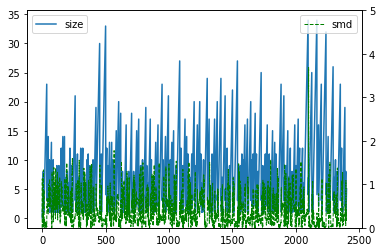

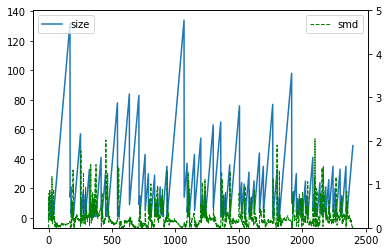

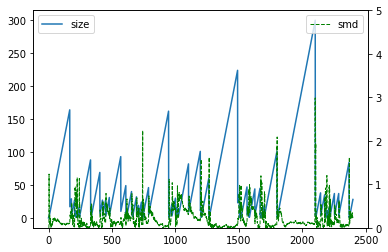

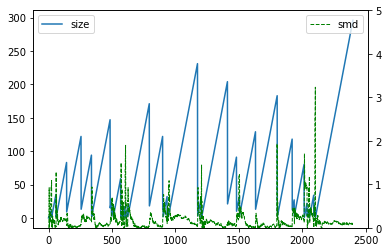

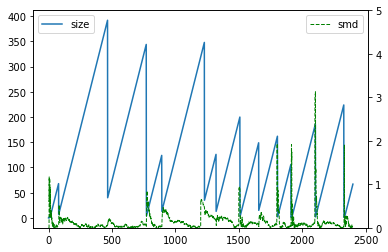

In [38]:
for i in range(5):
    show_size_and_smd_graph(results[i]["size_list"], results[i]["smd_list"])

for i in range(5):
    print(np.array(results[i]["smd_list"]).mean())

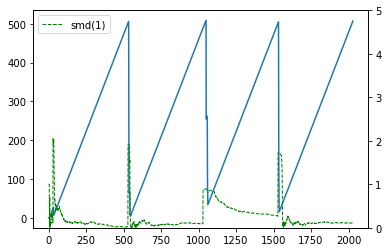

In [250]:
fig, ax1 = plt.subplots()
for i in range(1):
    ax1.plot(size_lists[i-1], label=f"size({i+1})")

ax2 = ax1.twinx()
ax2.set_ylim(0, 5)
for i in range(1):
    ax2.plot(smd_lists[i-1], label=f"smd({i+1})", color="green", linestyle = '--', linewidth = 1)
    
plt.legend(loc="upper left")

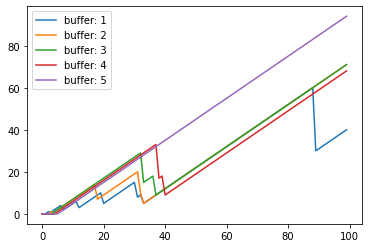

In [120]:
for i in range(1, 6):
    plt.plot(size_lists[i-1][:100], label=f"buffer: {i}")  
plt.legend(loc="upper left")

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 509.67it/s]


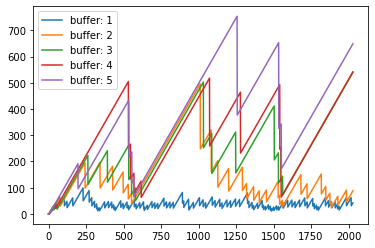

In [121]:
size_lists2 = []
for i in range(1, 6):
    model = Model()
    model.short_term_memory_buffer_size = i
    model.threshold_smoothing = 30
    size_list = test(model, distributions, trials)
    size_lists2.append(size_list)

for i in range(1, 6):
    plt.plot(size_lists2[i-1], label=f"buffer: {i}")  
plt.legend(loc="upper left")

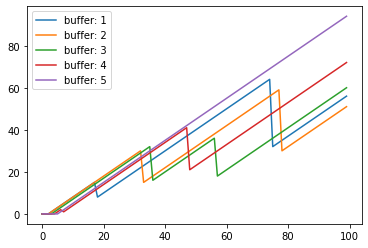

In [122]:
for i in range(1, 6):
    plt.plot(size_lists2[i-1][:100], label=f"buffer: {i}")  
plt.legend(loc="upper left")

0.2317137785453969